# The Opinions of Paul Krugman

### Barkat Sikder, Summer 2021

This notebook will retreive some of the opinions of Nobel-laureate economist Paul Krugman from the New York Times using their developer API. Then it will explore the nature of these opinions by modelling the topics discussed using the unsupervised machine learning method Latent Dirichlet Allocation (LDA) which is a part of the gensim package. Funally, it will try to understand the reactions to the opinion pieces by performing sentiment analysis on the user comments left by NYT patrons using nltk packagae's build in sentiment analyzer.


Some of the resources used to write this notebook are the following:

 https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

 https://realpython.com/python-nltk-sentiment-analysis/

In [3]:
# begin by importing some relevant packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import urllib
from bs4 import BeautifulSoup
import requests
import json

Next, get an API key to acces the NYT. Instructions can be viewed at: https://developer.nytimes.com/get-started

I was initially going to omit my own key, but for now, I'll keep it public...

In [4]:
# import API key

APIKEY = "2XXurKOlwFEQpnmlHlLpG8AuotpALvi5"

#with open('apikey.txt') as f:
    #apikey = f.readline()
    #f.close

In [5]:
# some helper functions for getting different links

#sections = [arts, automobiles, books, business, fashion, food, health, home, insider, magazine, movies, 
                #nyregion, obituaries, opinion, politics, realestate, science, sports, sundayreview, 
                #technology, theater, t-magazine, travel, upshot, us, world] 

def get_url_topstories(section):
    url = ("https://api.nytimes.com/svc/topstories/v2/{}.json?api-key={}".format(section, APIKEY))
    return url

def get_url_moviereviews(all_or_pick, offset, order):
    # multiple of 20
    # by-opening-date, by-publication-date
    url = ("https://api.nytimes.com/svc/movies/v2/reviews/all.json?api-key={}".format(APIKEY))#, offset, order,)) &offset={}&order={}
    return url



def get_url_articlesearch(q):#, startdate, enddate):
    url = ("https://api.nytimes.com/svc/search/v2/articlesearch.json?q={}&api-key={}".format(q, APIKEY))
    return url

def get_url_usercomments(article_link):
    url = ("https://api.nytimes.com/svc/community/v3/user-content/url.json?api-key={}&offset=0&url={}".format(APIKEY, article_link))
    return url



In [35]:
#r_topstories = requests.get(get_url_topstories("arts"))
#df_topstories = pd.json_normalize(r_topstories.json()['results'])
#df_topstories.head()

In [34]:
#r_moviereviews = requests.get(get_url_moviereviews("all", "", ""))
#print(r_moviereviews.json())
#df_moviereviews = pd.json_normalize(r_moviereviews.json()['results'])
#df_moviereviews.head()

In [6]:
# Comments

#article_link = "https://www.nytimes.com/2021/08/09/opinion/aging-nursing-home-medicare.html"
#r_usercomments = requests.get(get_url_usercomments(article_link))
#df_usercomments = pd.json_normalize(r_usercomments.json()['results']["comments"])
#df_usercomments.info()

# SECTION A: Topic Modelling with LDA

## STEP 1: Retrieve Raw Articles by Krugman

As the title suggests, we use the requests package to requests articles that return json files. The schemas for the json files can be found on the NYT developer portal. Convert it into a pandas df and then clean for the variables we need.

In [7]:
# use article search helper function to get the articles

r_krugman = requests.get(get_url_articlesearch("krugman"))
#print(r_krugman.json())

In [8]:
# structure the json file retrieved into a pandas df that can be worked with

df_krugman = pd.json_normalize(r_krugman.json()['response']['docs'])
df_krugman.head()

,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,keywords,pub_date,...,headline.main,headline.kicker,headline.content_kicker,headline.print_headline,headline.name,headline.seo,headline.sub,byline.original,byline.person,byline.organization
0,It wants to prioritize low taxes over the fate...,https://www.nytimes.com/2021/09/02/opinion/cor...,It wants to prioritize low taxes over the fate...,Why does Mickey Mouse want to destroy civiliza...,A,22,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","[{'name': 'subject', 'value': 'Greenhouse Gas ...",2021-09-02T23:00:09+0000,...,Corporate America Is Lobbying for Climate Disa...,Paul Krugman,None,Corporate America Is Lobbying for Climate Disa...,None,None,None,By Paul Krugman,"[{'firstname': 'Paul', 'middlename': None, 'la...",None
1,Government officials can be corrupted — but so...,https://www.nytimes.com/2021/08/31/opinion/gov...,Government officials can be corrupted — but so...,Today’s column was inspired by the latest twis...,NaN,NaN,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","[{'name': 'subject', 'value': 'International T...",2021-08-31T17:00:07+0000,...,The Buying of the American Mind,Paul Krugman,None,None,None,None,None,By Paul Krugman,"[{'firstname': 'Paul', 'middlename': None, 'la...",None
2,How the nutritional supplement business has he...,https://www.nytimes.com/2021/08/30/opinion/cov...,How the nutritional supplement business has he...,You don’t hear much these days about “economic...,A,23,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","[{'name': 'subject', 'value': 'Fringe Groups a...",2021-08-30T23:28:50+0000,...,The Snake Oil Theory of the Modern Right,Paul Krugman,None,The Snake Oil Theory of the Modern Right,None,None,None,By Paul Krugman,"[{'firstname': 'Paul', 'middlename': None, 'la...",None
3,The troubling interaction between NIMBYs and t...,https://www.nytimes.com/2021/08/27/opinion/Cal...,The troubling interaction between NIMBYs and t...,"In my latest column, motivated by the Californ...",NaN,NaN,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","[{'name': 'subject', 'value': 'International T...",2021-08-27T15:37:42+0000,...,The Gentrification of Blue America,Paul Krugman,None,None,None,None,None,By Paul Krugman,"[{'firstname': 'Paul', 'middlename': None, 'la...",None
4,A crazy recall process could lead to repudiati...,https://www.nytimes.com/2021/08/26/opinion/cal...,A crazy recall process could lead to repudiati...,If you live in California and haven’t yet vote...,A,19,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","[{'name': 'glocations', 'value': 'California',...",2021-08-26T23:00:08+0000,...,California Could Throw Away What It’s Won,Paul Krugman,None,California May Throw Away What It’s Won,None,None,None,By Paul Krugman,"[{'firstname': 'Paul', 'middlename': None, 'la...",None


In [9]:
# see how many articles have been retrieved

len(df_krugman)

10

In [10]:
# keep only whats needed

krugman_articles = df_krugman[["headline.kicker", "headline.main", "abstract", "pub_date", 
                               "web_url", "lead_paragraph", "keywords"]]
krugman_articles.head()

,headline.kicker,headline.main,abstract,pub_date,web_url,lead_paragraph,keywords
0,Paul Krugman,Corporate America Is Lobbying for Climate Disa...,It wants to prioritize low taxes over the fate...,2021-09-02T23:00:09+0000,https://www.nytimes.com/2021/09/02/opinion/cor...,Why does Mickey Mouse want to destroy civiliza...,"[{'name': 'subject', 'value': 'Greenhouse Gas ..."
1,Paul Krugman,The Buying of the American Mind,Government officials can be corrupted — but so...,2021-08-31T17:00:07+0000,https://www.nytimes.com/2021/08/31/opinion/gov...,Today’s column was inspired by the latest twis...,"[{'name': 'subject', 'value': 'International T..."
2,Paul Krugman,The Snake Oil Theory of the Modern Right,How the nutritional supplement business has he...,2021-08-30T23:28:50+0000,https://www.nytimes.com/2021/08/30/opinion/cov...,You don’t hear much these days about “economic...,"[{'name': 'subject', 'value': 'Fringe Groups a..."
3,Paul Krugman,The Gentrification of Blue America,The troubling interaction between NIMBYs and t...,2021-08-27T15:37:42+0000,https://www.nytimes.com/2021/08/27/opinion/Cal...,"In my latest column, motivated by the Californ...","[{'name': 'subject', 'value': 'International T..."
4,Paul Krugman,California Could Throw Away What It’s Won,A crazy recall process could lead to repudiati...,2021-08-26T23:00:08+0000,https://www.nytimes.com/2021/08/26/opinion/cal...,If you live in California and haven’t yet vote...,"[{'name': 'glocations', 'value': 'California',..."


In [11]:
# gives us a sense of the first paragraph of each article

krugman_articles["lead_paragraph"][0]

'Why does Mickey Mouse want to destroy civilization?'

## STEP 2: Preprocess Text Data

We now want to use the basic NLP tools such as nltk to preprocess the text and create a format that can then be fed into the gensim LDA model.


In [12]:
# import some more libraries

import string
import re
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import warnings
warnings.filterwarnings("ignore")

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [13]:
# and then even more libraries

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer


In [14]:
# to get rid of stop words, which are those irrelevant for our model
# we need to initialize what those words are, so we can use later

stop_words = stopwords.words('english')
# extend the list based on necessity 
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [15]:
# first, take the string of words in the abstract and turn it into a list of words

# Convert to list
data = krugman_articles.abstract.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))



In [16]:
print(data_words)

[['it', 'wants', 'to', 'prioritize', 'low', 'taxes', 'over', 'the', 'fate', 'of', 'civilization'], ['government', 'officials', 'can', 'be', 'corrupted', 'but', 'so', 'can', 'their', 'critics'], ['how', 'the', 'nutritional', 'supplement', 'business', 'has', 'helped', 'foster', 'extremism'], ['the', 'troubling', 'interaction', 'between', 'nimbys', 'and', 'the', 'knowledge', 'economy'], ['crazy', 'recall', 'process', 'could', 'lead', 'to', 'repudiation', 'of', 'the', 'state', 'policy', 'successes'], ['punishing', 'the', 'unemployed', 'doesn', 'accomplish', 'very', 'much'], ['pandemic', 'lesson', 'you', 'can', 'say', 'no', 'to', 'bad', 'pay', 'and', 'conditions'], ['globalization', 'and', 'the', 'power', 'of', 'ideas'], ['it', 'time', 'to', 'stop', 'being', 'diffident', 'and', 'speak', 'up'], ['was', 'it', 'luck', 'or', 'was', 'it', 'good', 'policy']]


Now that we have a list of words, we want to create n-grams. Or essentially phrases. For now, we will focus on bigrams.

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)


## we're not working with trigrams for now

# See trigram example
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
#trigram_mod = gensim.models.phrases.Phraser(trigram)
#print(trigram_mod[bigram_mod[data_words[0]]])

In [18]:
# Define functions for stopwords, bigrams

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


## focus on lemmatized later ??

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

In [22]:
# check 1: see if functions worked properly

print(data_words_nostops)

[['wants', 'prioritize', 'low', 'taxes', 'fate', 'civilization'], ['government', 'officials', 'corrupted', 'critics'], ['nutritional', 'supplement', 'business', 'helped', 'foster', 'extremism'], ['troubling', 'interaction', 'nimbys', 'knowledge', 'economy'], ['crazy', 'recall', 'process', 'could', 'lead', 'repudiation', 'state', 'policy', 'successes'], ['punishing', 'unemployed', 'accomplish', 'much'], ['pandemic', 'lesson', 'say', 'bad', 'pay', 'conditions'], ['globalization', 'power', 'ideas'], ['time', 'stop', 'diffident', 'speak'], ['luck', 'good', 'policy']]


In [23]:
# check 2: this should be dif from above

print(data_words_bigrams)

[['wants', 'prioritize', 'low', 'taxes', 'fate', 'civilization'], ['government', 'officials', 'corrupted', 'critics'], ['nutritional', 'supplement', 'business', 'helped', 'foster', 'extremism'], ['troubling', 'interaction', 'nimbys', 'knowledge', 'economy'], ['crazy', 'recall', 'process', 'could', 'lead', 'repudiation', 'state', 'policy', 'successes'], ['punishing', 'unemployed', 'accomplish', 'much'], ['pandemic', 'lesson', 'say', 'bad', 'pay', 'conditions'], ['globalization', 'power', 'ideas'], ['time', 'stop', 'diffident', 'speak'], ['luck', 'good', 'policy']]


In [24]:
# check 3

#print(data_lemmatized)

NameError: name 'data_lemmatized' is not defined

The dictionary is such that unique id maps to each word/phrase. In the corpus, for each document, we have a list of tuples (a,b) such that a is the word id and b is the frequency in the document. This is the format of the bag of words model that the gensim LDA accepts.

In [25]:
# temp
data_lemmatized = data_words_bigrams

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [26]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('civilization', 1),
  ('fate', 1),
  ('low', 1),
  ('prioritize', 1),
  ('taxes', 1),
  ('wants', 1)]]

## Run LDA model and evaluate

At this point, we just want to run the model and evaluate it based on certain metrics, namely the perplexity and coherence values. 

In [42]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"policy" + 0.020*"much" + 0.020*"good" + 0.020*"globalization" + '
  '0.020*"power" + 0.020*"luck" + 0.020*"critics" + 0.020*"troubling" + '
  '0.020*"time" + 0.020*"stop"'),
 (1,
  '0.020*"policy" + 0.020*"much" + 0.020*"good" + 0.020*"time" + 0.020*"ideas" '
  '+ 0.020*"globalization" + 0.020*"diffident" + 0.020*"stop" + 0.020*"power" '
  '+ 0.020*"knowledge"'),
 (2,
  '0.101*"policy" + 0.101*"power" + 0.101*"globalization" + 0.101*"ideas" + '
  '0.101*"good" + 0.101*"luck" + 0.009*"time" + 0.009*"much" + 0.009*"stop" + '
  '0.009*"speak"'),
 (3,
  '0.079*"state" + 0.079*"crazy" + 0.079*"could" + 0.079*"successes" + '
  '0.079*"lead" + 0.079*"process" + 0.079*"recall" + 0.079*"repudiation" + '
  '0.079*"policy" + 0.007*"ideas"'),
 (4,
  '0.074*"civilization" + 0.074*"low" + 0.074*"prioritize" + 0.074*"taxes" + '
  '0.074*"wants" + 0.074*"fate" + 0.074*"speak" + 0.074*"diffident" + '
  '0.074*"stop" + 0.074*"time"'),
 (5,
  '0.074*"conditions" + 0.074*"lesson" + 0.074*"s

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score - higher the better
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.982270257472992


/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.6370015044380015


In [45]:
# https://stackoverflow.com/questions/66759852/no-module-named-pyldavis 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
# feed the LDA model into the pyLDAvis instance
#lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary


# Visualize the topics
# https://stackoverflow.com/questions/46379763/typeerror-object-of-type-complex-is-not-json-serializable-while-using-pyldavi
vis = gensimvis.prepare(lda_model, corpus, id2word, mds='mmds')
vis

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias f

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.192329 -0.007593       1        1  19.310813
5      0.087883  0.167592       2        1  19.310810
3     -0.144997 -0.118544       3        1  17.915434
8     -0.079659  0.141664       4        1  11.940865
2      0.020069 -0.165244       5        1  11.412380
6     -0.132746  0.031203       6        1   9.956771
7      0.054298 -0.068242       7        1   7.980622
0      0.000941  0.006388       8        1   0.724106
9      0.000941  0.006388       9        1   0.724100
1      0.000941  0.006388      10        1   0.724099, topic_info=          Term      Freq     Total Category  logprob  loglift
24      policy  1.000000  1.000000  Default  30.0000  30.0000
6    corrupted  0.000000  0.000000  Default  29.0000  29.0000
8   government  0.000000  0.000000  Default  28.0000  28.0000
7      critics  0.000000  0.000000  Default  27.0000  27.0000
9    officials  0.000000  0.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
34         bad  0.007389  1.066474  Topic10  -3.8918  -0.0442
37    pandemic  0.007389  1.066474  Topic10  -3.8918  -0.0442
39         say  0.007389  1.066474  Topic10  -3.8918  -0.0442
2          low  0.007389  1.066474  Topic10  -3.8918  -0.0442
4        taxes  0.007389  1.066474  Topic10  -3.8918  -0.0442

[438 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
30        2  0.937670     accomplish
34        2  0.937670            bad
10        4  1.034976       business
0         1  0.937670   civilization
35        2  0.937670     conditions
21        3  0.940822          could
22        3  0.940822          crazy
43        1  0.937670      diffident
16        6  1.085391        economy
11        4  1.034976      extremism
1         1  0.937670           fate
12        4  1.034976         foster
40        5  1.061612  globalization
47        5  1.061612           good
13        4  1.034976         helped
41        5  1.061612          ideas
17        6  1.085391    interaction
18        6  1.085391      knowledge
23        3  0.940822           lead
36        2  0.937670         lesson
2         1  0.937670            low
48        5  1.061612           luck
31        2  0.937670           much
19        6  1.085391         nimbys
14        4  1.034976    nutritional
37        2  0.937670       pandemic
38        2  0.937670            pay
24        3  0.630357         policy
24        5  0.630357         policy
42        5  1.061612          power
3         1  0.937670     prioritize
25        3  0.940822        process
32        2  0.937670      punishing
26        3  0.940822         recall
27        3  0.940822    repudiation
39        2  0.937670            say
44        1  0.937670          speak
28        3  0.940822          state
45        1  0.937670           stop
29        3  0.940822      successes
15        4  1.034976     supplement
4         1  0.937670          taxes
46        1  0.937670           time
20        6  1.085391      troubling
33        2  0.937670     unemployed
5         1  0.937670          wants, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 4, 9, 3, 7, 8, 1, 10, 2])

In [ ]:
#find optimal number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)



In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [37]:
model_list[1]

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.020*"much" + 0.020*"accomplish" + 0.020*"bad" + 0.020*"unemployed" + '
  '0.020*"punishing" + 0.020*"lesson" + 0.020*"repudiation" + 0.020*"state" + '
  '0.020*"pay" + 0.020*"successes"'),
 (1,
  '0.020*"much" + 0.020*"accomplish" + 0.020*"bad" + 0.020*"unemployed" + '
  '0.020*"punishing" + 0.020*"lesson" + 0.020*"repudiation" + 0.020*"state" + '
  '0.020*"pay" + 0.020*"successes"'),
 (2,
  '0.020*"much" + 0.020*"accomplish" + 0.020*"bad" + 0.020*"unemployed" + '
  '0.020*"punishing" + 0.020*"lesson" + 0.020*"repudiation" + 0.020*"state" + '
  '0.020*"pay" + 0.020*"successes"'),
 (3,
  '0.193*"power" + 0.193*"ideas" + 0.193*"globalization" + 0.009*"much" + '
  '0.009*"unemployed" + 0.009*"punishing" + 0.009*"conditions" + '
  '0.009*"repudiation" + 0.009*"successes" + 0.009*"pay"'),
 (4,
  '0.163*"accomplish" + 0.163*"punishing" + 0.163*"much" + 0.163*"unemployed" '
  '+ 0.008*"bad" + 0.008*"lesson" + 0.008*"repudiation" + 0.008*"state" + '
  '0.008*"pay" + 0.008*"successes"

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## STEP 3: Asking Questions

Let's ask a series of questions about Krugman's articles.

- Finding the dominant topic in each sentence
- Most representative document for each topic
- Topic distribution across documents
- The most representative sentence for each topic
- Frequency Distribution of Word Counts in Documents
- What are the most discussed topics in the documents?

### 1: Finding the dominant topic in each sentence

In [50]:
# Finding the dominant topic in each sentence

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,12.0,0.8643,"civilization, prioritize, low, taxes, fate, wa...",It wants to prioritize low taxes over the fate...
1,1,18.0,0.8100,"critics, corrupted, government, officials, con...",Government officials can be corrupted — but so...
2,2,6.0,0.8643,"extremism, business, helped, supplement, nutri...",How the nutritional supplement business has he...
3,3,7.0,0.8417,"conditions, knowledge, pandemic, economy, say,...",The troubling interaction between NIMBYs and t...
4,4,15.0,0.9050,"process, repudiation, policy, lead, diffident,...",A crazy recall process could lead to repudiati...
5,5,4.0,0.8100,"accomplish, punishing, much, unemployed, bad, ...",Punishing the unemployed doesn’t accomplish ve...
6,6,7.0,0.8643,"conditions, knowledge, pandemic, economy, say,...",A pandemic lesson: You can say no to bad pay a...
7,7,3.0,0.7625,"power, ideas, globalization, much, unemployed,...",Globalization and the power of ideas.
8,8,15.0,0.8100,"process, repudiation, policy, lead, diffident,...",It’s time to stop being diffident and speak up.
9,9,14.0,0.7625,"luck, policy, good, punishing, accomplish, bad...","Was it luck, or was it good policy?"


### 2: Most representative document for each topic

In [51]:
## Most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,3.0,0.7625,"power, ideas, globalization, much, unemployed,...",Globalization and the power of ideas.
1,4.0,0.8100,"accomplish, punishing, much, unemployed, bad, ...",Punishing the unemployed doesn’t accomplish ve...
2,6.0,0.8643,"extremism, business, helped, supplement, nutri...",How the nutritional supplement business has he...
3,7.0,0.8643,"conditions, knowledge, pandemic, economy, say,...",A pandemic lesson: You can say no to bad pay a...
4,12.0,0.8643,"civilization, prioritize, low, taxes, fate, wa...",It wants to prioritize low taxes over the fate...


### 3: Topic distribution across documents

In [52]:
## topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,12.0,"civilization, prioritize, low, taxes, fate, wa...",NaN,NaN
1.0,18.0,"critics, corrupted, government, officials, con...",NaN,NaN
2.0,6.0,"extremism, business, helped, supplement, nutri...",NaN,NaN
3.0,7.0,"conditions, knowledge, pandemic, economy, say,...",1.0,0.1
4.0,15.0,"process, repudiation, policy, lead, diffident,...",1.0,0.1
5.0,4.0,"accomplish, punishing, much, unemployed, bad, ...",NaN,NaN
6.0,7.0,"conditions, knowledge, pandemic, economy, say,...",1.0,0.1
7.0,3.0,"power, ideas, globalization, much, unemployed,...",2.0,0.2
8.0,15.0,"process, repudiation, policy, lead, diffident,...",NaN,NaN
9.0,14.0,"luck, policy, good, punishing, accomplish, bad...",NaN,NaN


In [ ]:
### next step more visualization

### 4: The most representative sentence for each topic

In [53]:
## The most representative sentence for each topic

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,3.0,0.7625,"power, ideas, globalization, much, unemployed, punishing, conditions, repudiation, successes, pay",Globalization and the power of ideas.
1,4.0,0.8100,"accomplish, punishing, much, unemployed, bad, lesson, repudiation, state, pay, successes",Punishing the unemployed doesn’t accomplish very much.
2,6.0,0.8643,"extremism, business, helped, supplement, nutritional, foster, accomplish, pandemic, pay, unemployed",How the nutritional supplement business has helped foster extremism.
3,7.0,0.8643,"conditions, knowledge, pandemic, economy, say, nimbys, pay, troubling, lesson, interaction",A pandemic lesson: You can say no to bad pay and conditions.
4,12.0,0.8643,"civilization, prioritize, low, taxes, fate, wants, bad, accomplish, conditions, pandemic",It wants to prioritize low taxes over the fate of civilization.
5,14.0,0.7625,"luck, policy, good, punishing, accomplish, bad, unemployed, lesson, much, successes","Was it luck, or was it good policy?"
6,15.0,0.9050,"process, repudiation, policy, lead, diffident, recall, crazy, stop, successes, speak",A crazy recall process could lead to repudiation of the state’s policy successes.
7,18.0,0.8100,"critics, corrupted, government, officials, conditions, bad, unemployed, pandemic, successes, much",Government officials can be corrupted — but so can their critics.


### 5: Frequency Distribution of Word Counts in Documents

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


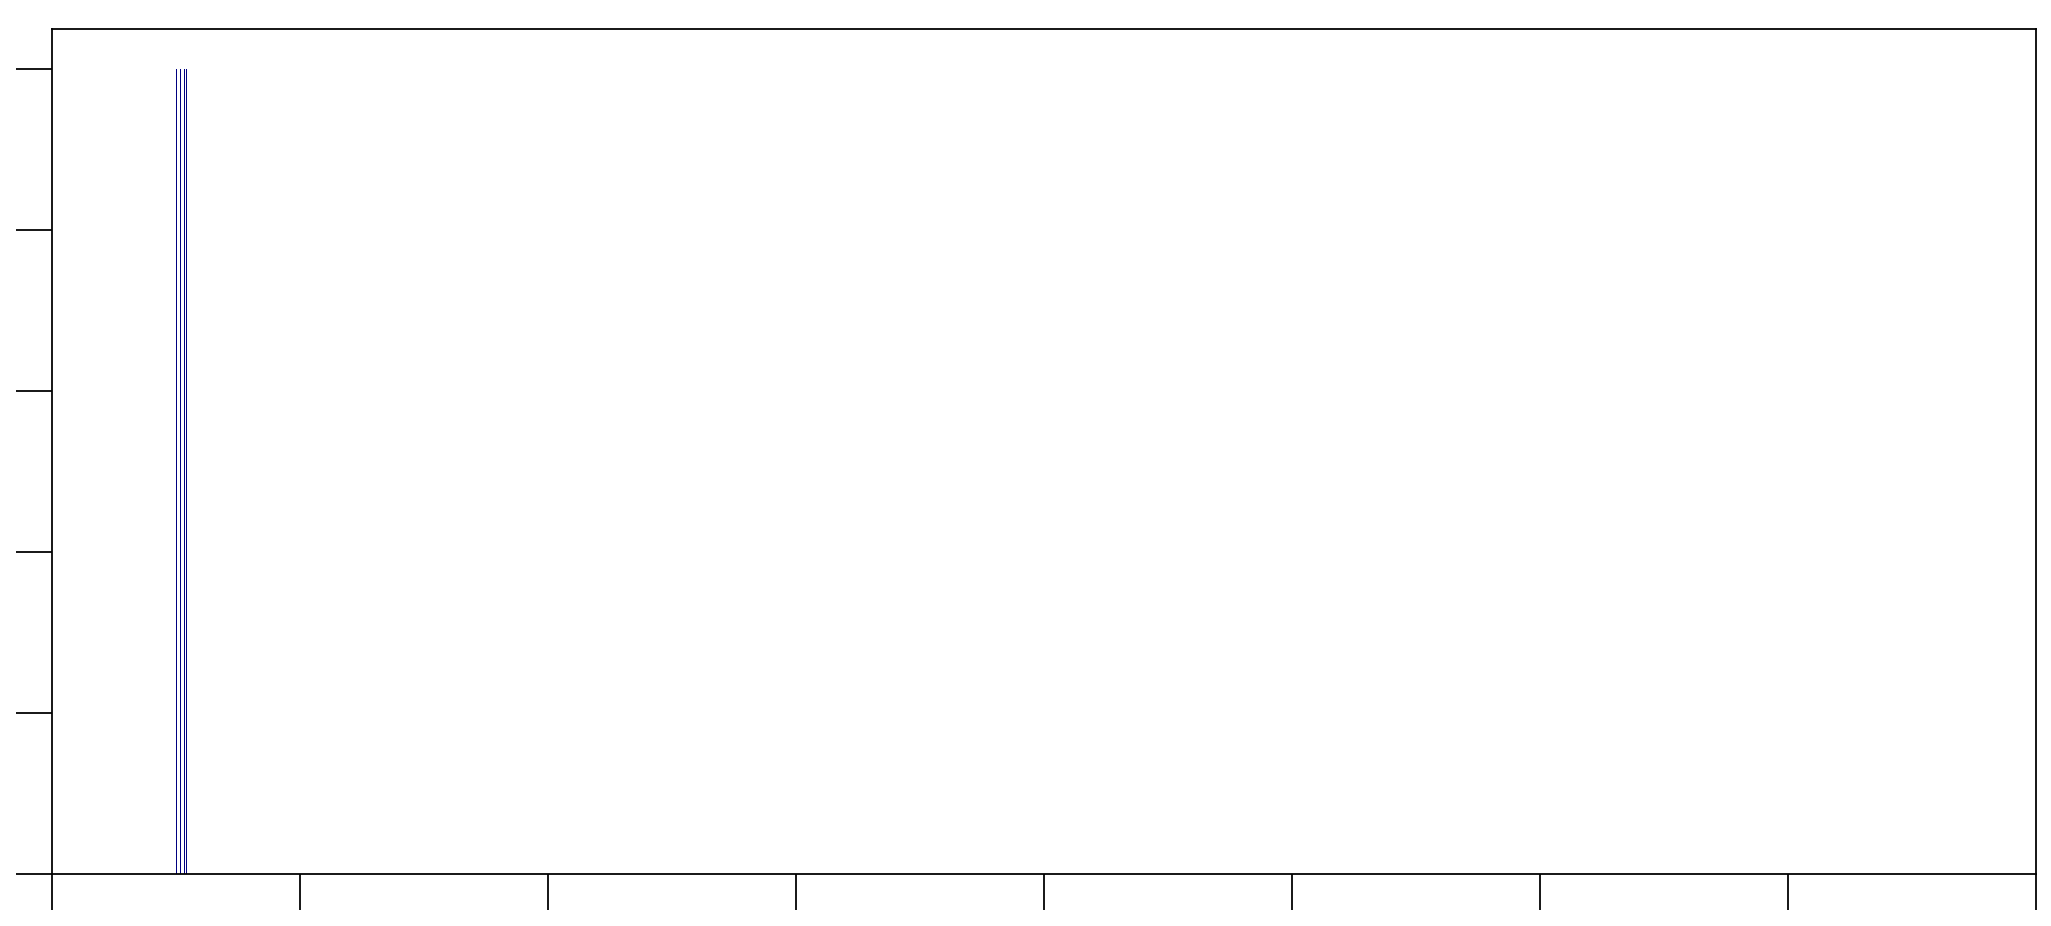

In [54]:
## Frequency Distribution of Word Counts in Documents

doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


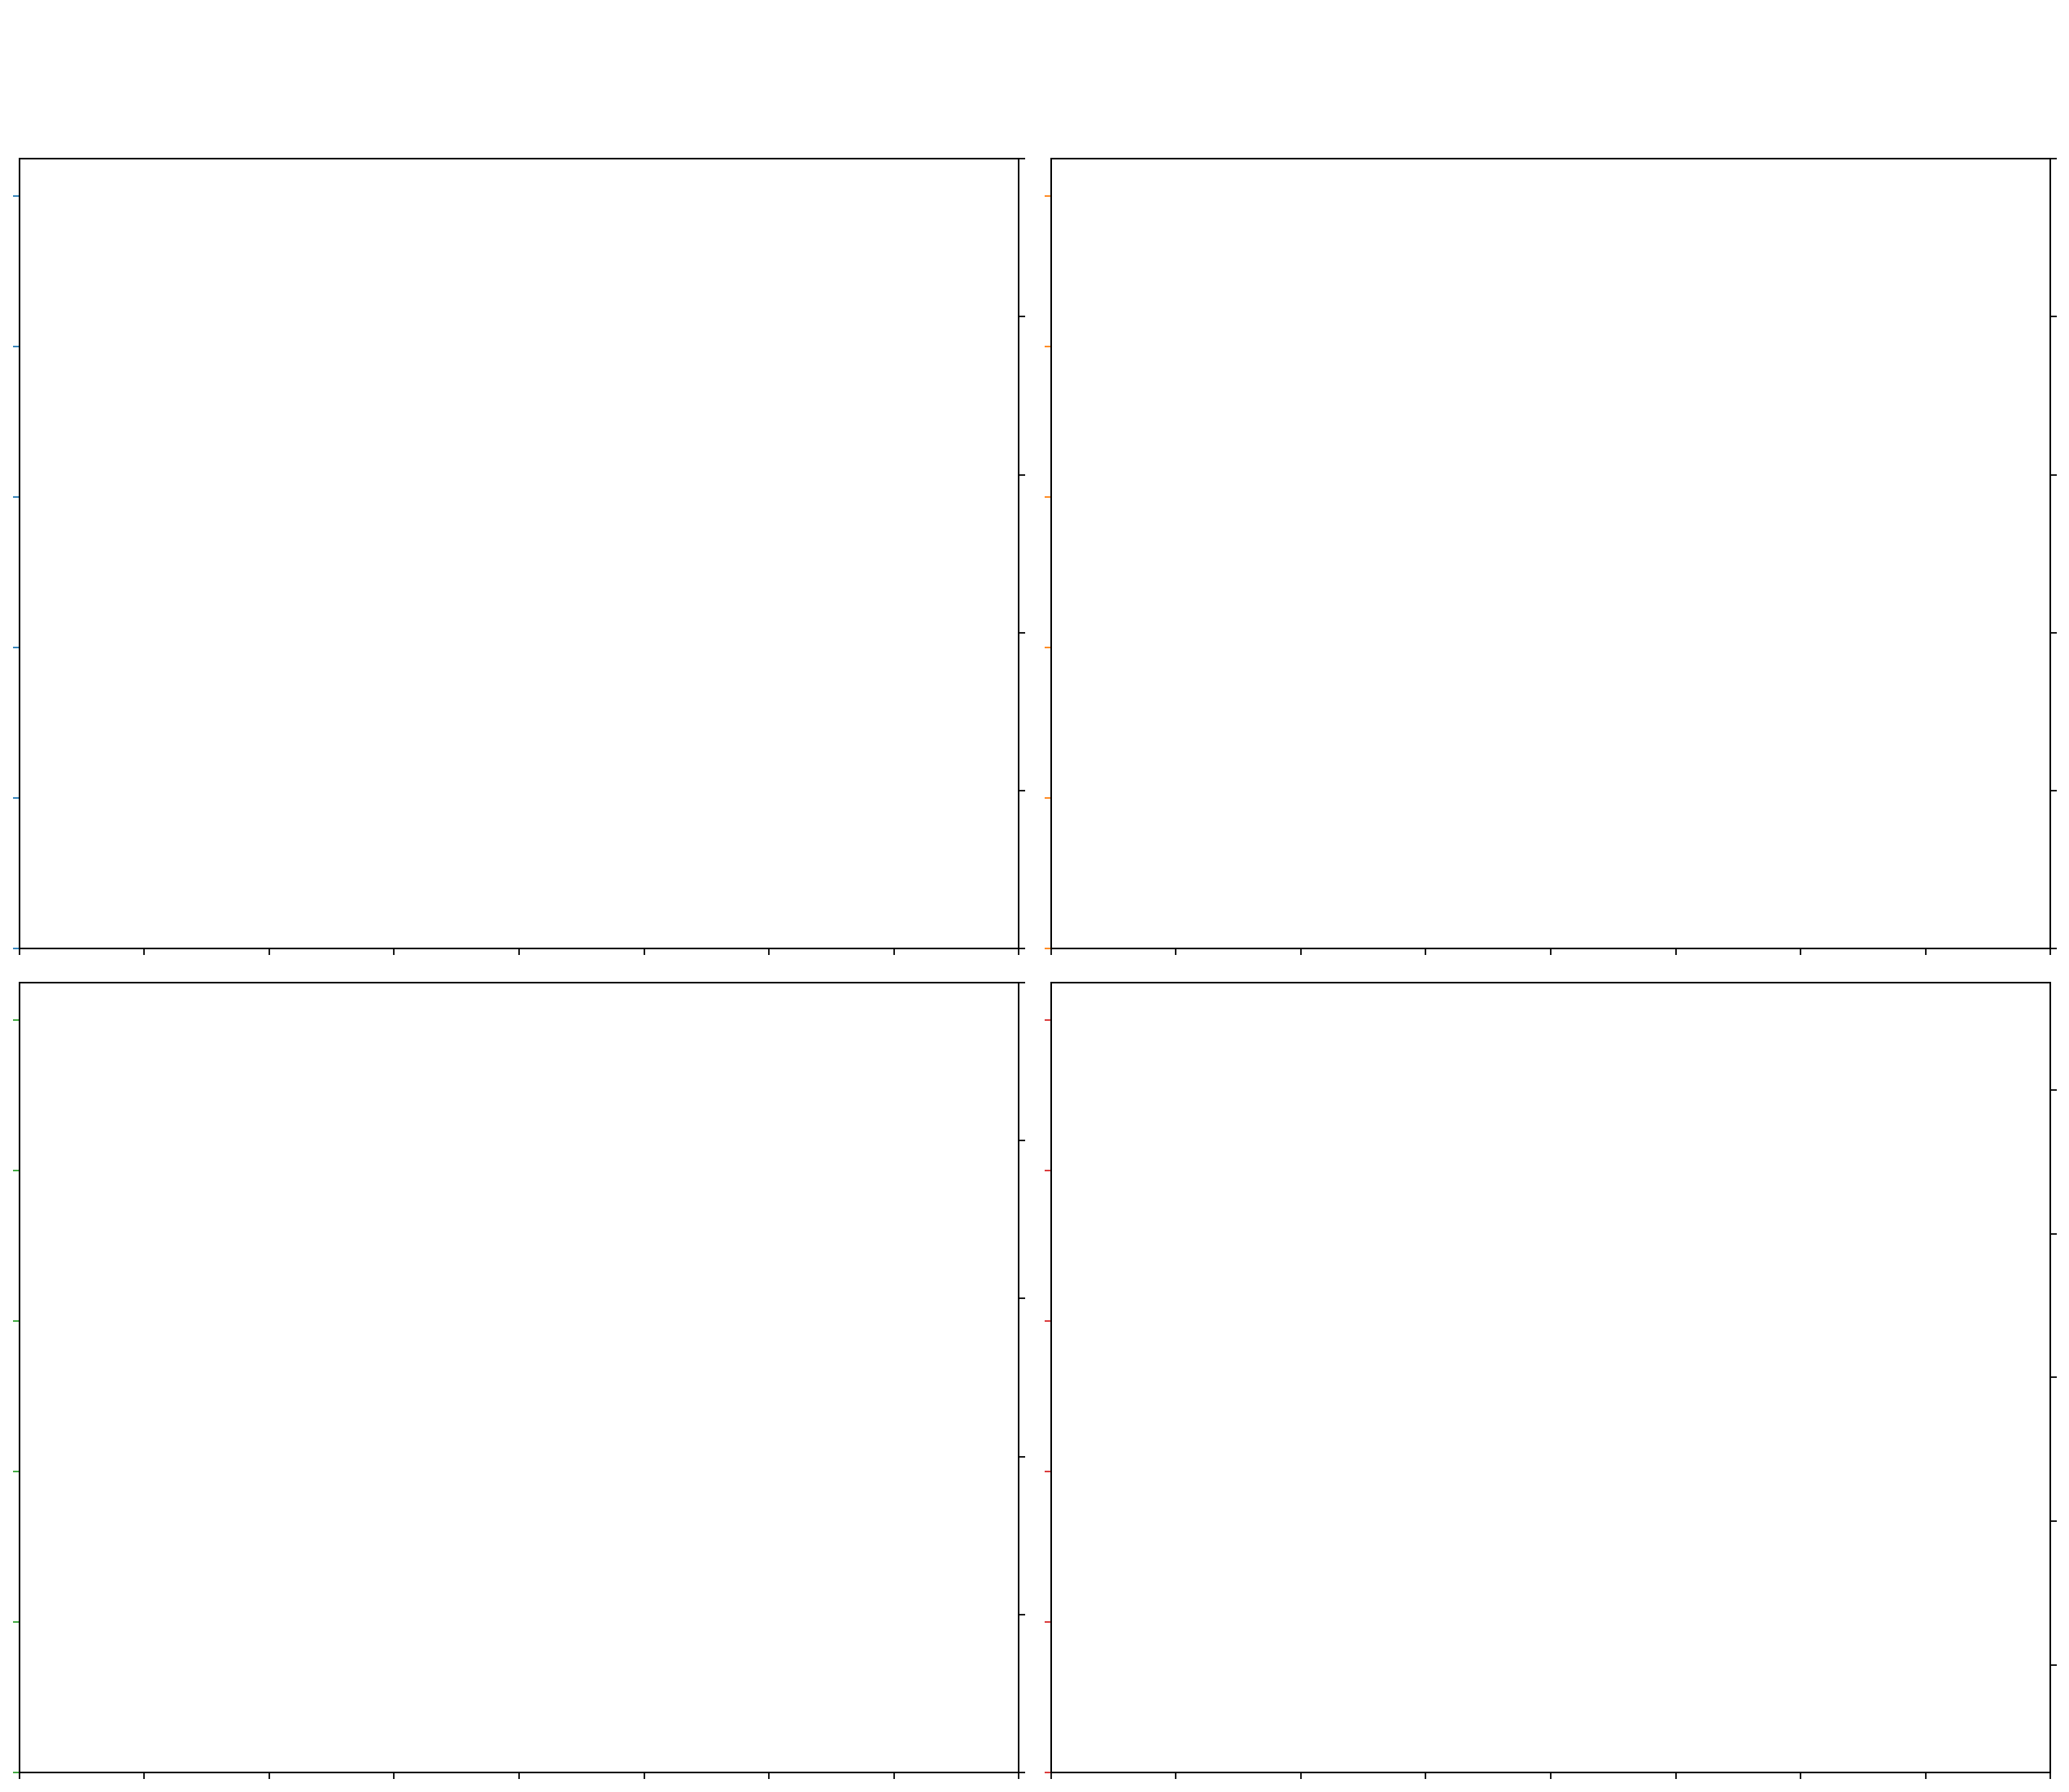

In [55]:
# also

import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [56]:
# word cloud

# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: No module named 'wordcloud'

### 6: Word Counts of Topic Keywords

In [57]:
# Word Counts of Topic Keywords

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'data_ready' is not defined

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: list index out of range

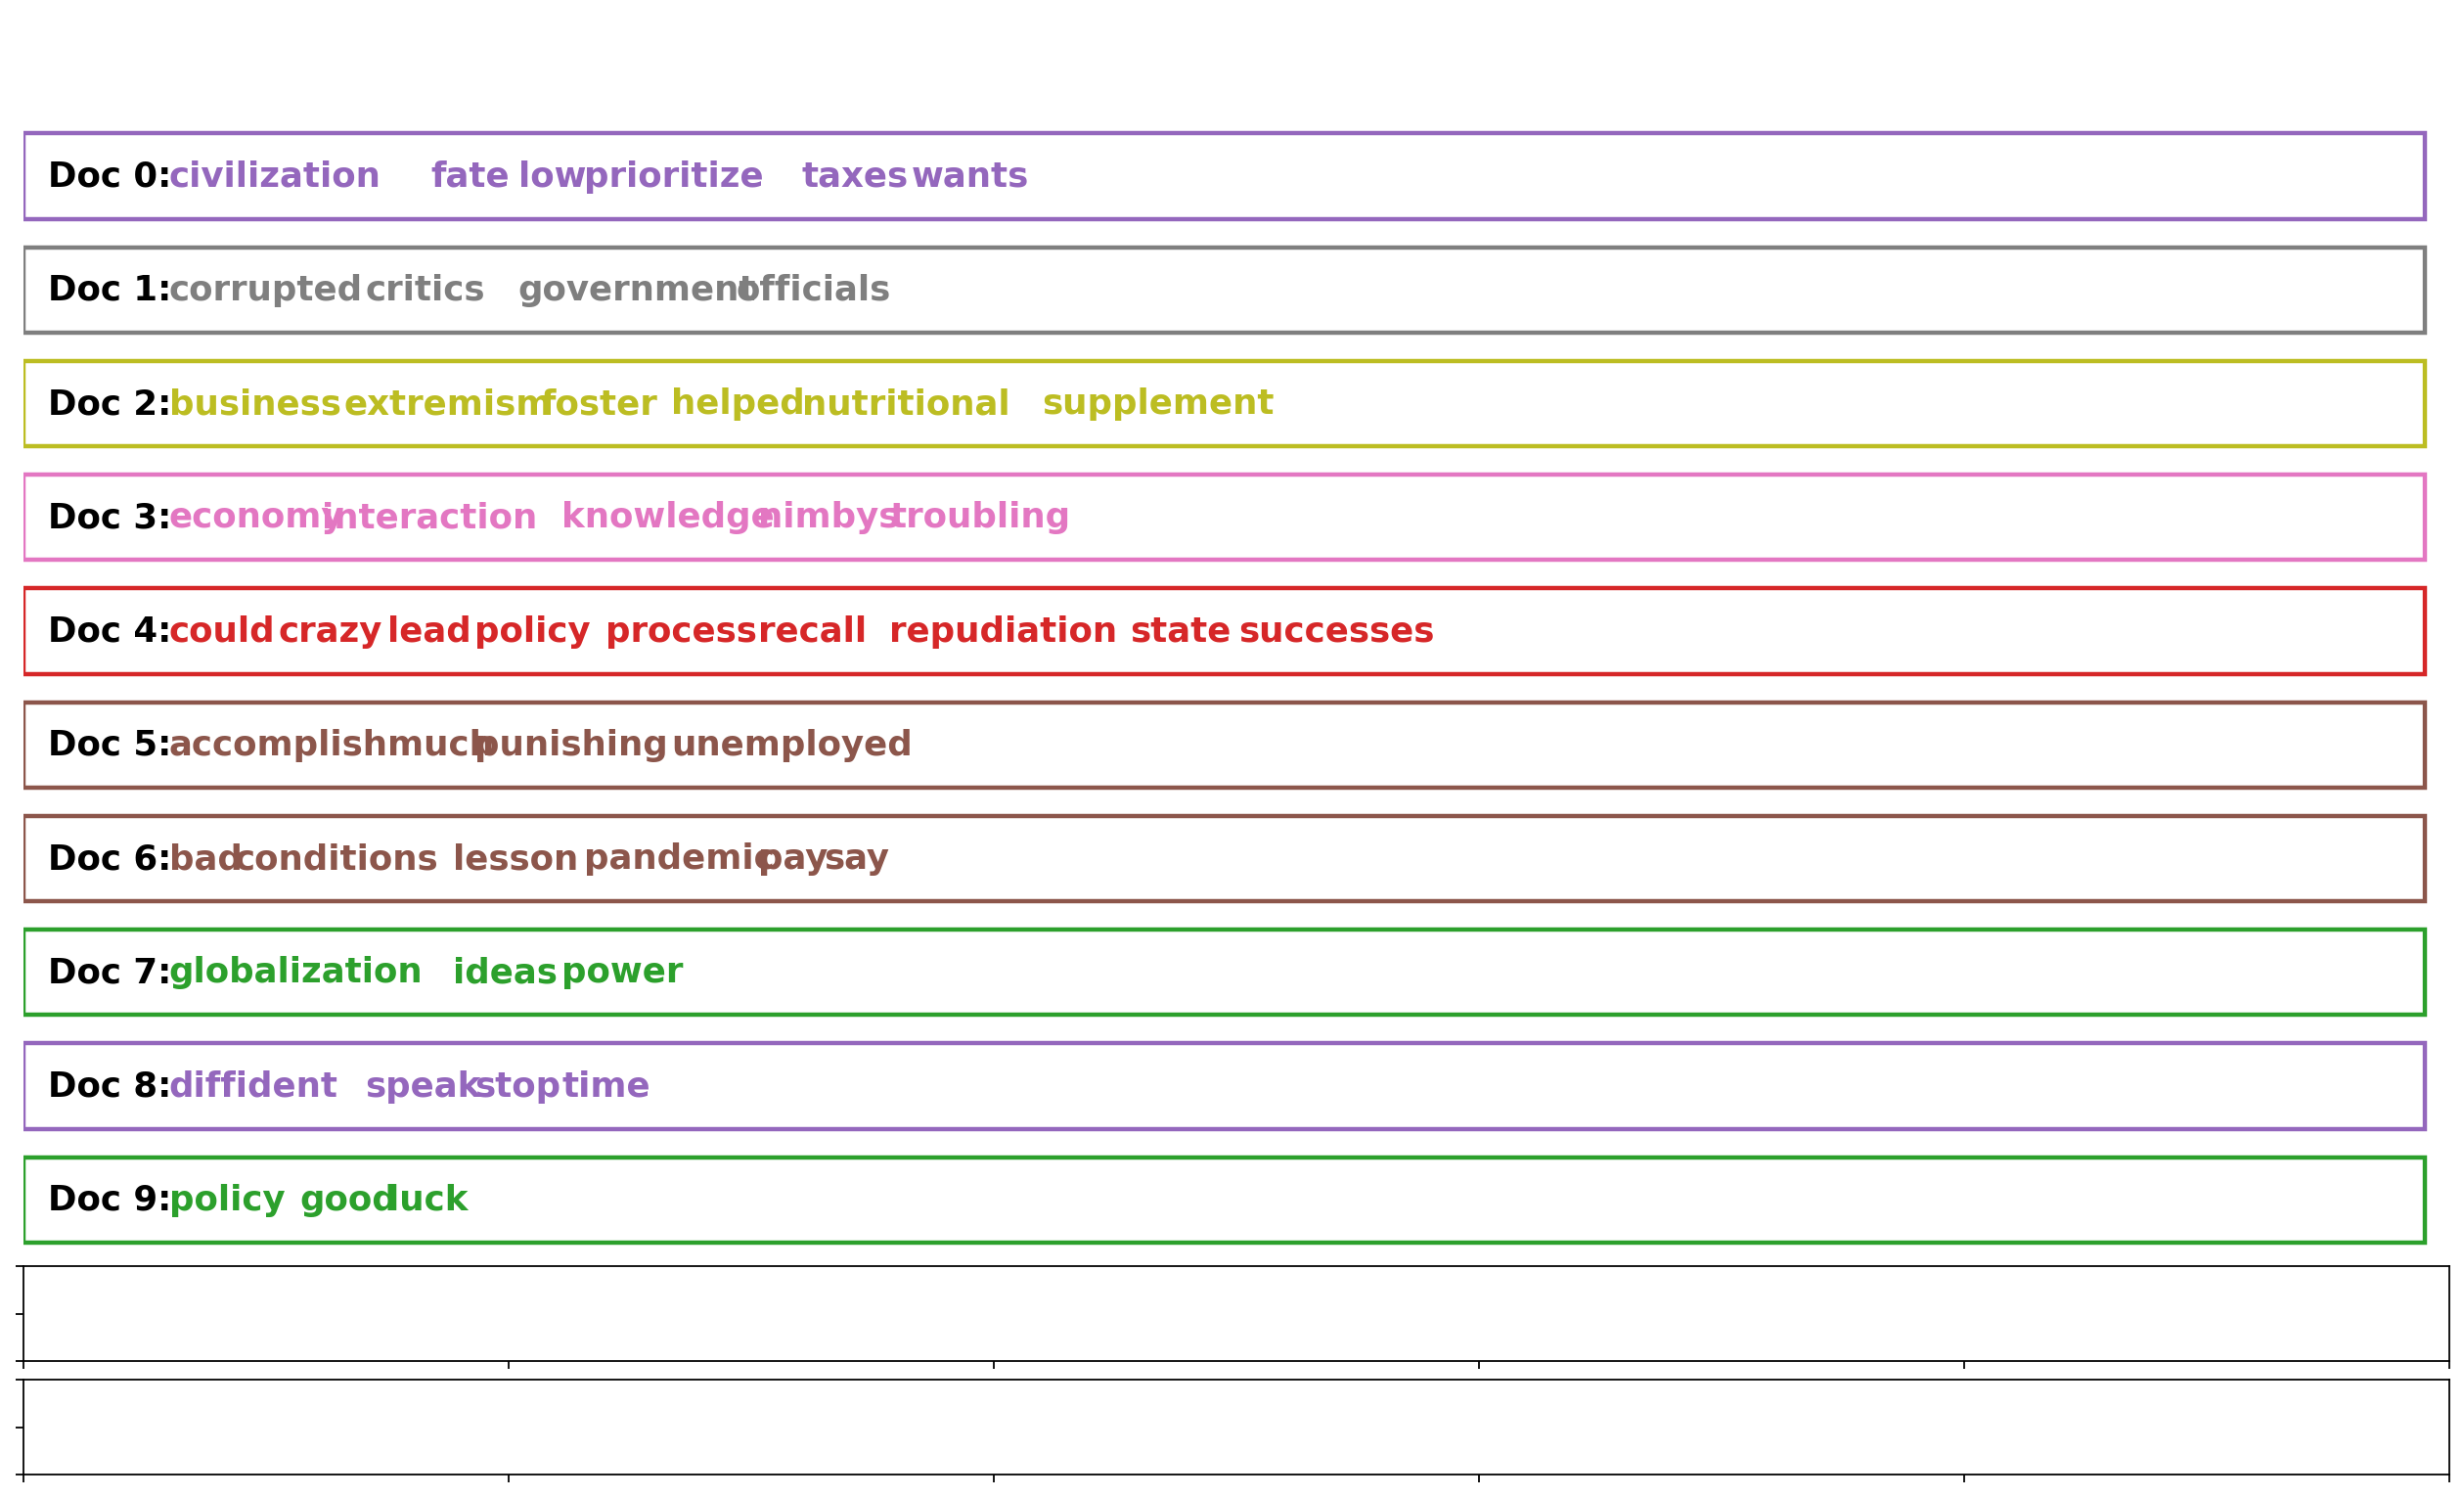

In [58]:
# Sentence Chart Colored by Topic


# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

### 7: What are the most discussed topics in the documents?

In [59]:
# What are the most discussed topics in the documents?


# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


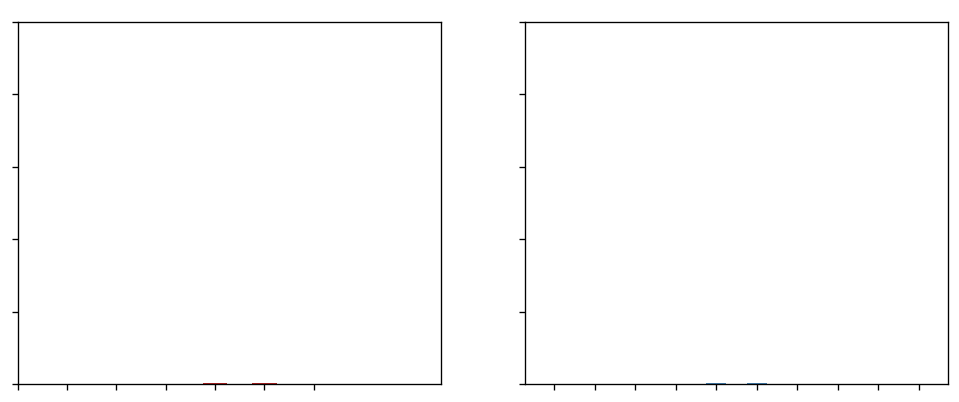

In [60]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [61]:
# t-SNE

# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/Users/barkatsikder/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: No module named 'bokeh'

In [ ]:
# pLDAvis

# Section B: Sentiment Analysis on User Comments



In [65]:
krugman_articles.head()

,headline.kicker,headline.main,abstract,pub_date,web_url,lead_paragraph,keywords
0,Paul Krugman,"Honey, Who Shrunk the World?",Globalization and the power of ideas.,2021-08-20T16:23:42+0000,https://www.nytimes.com/2021/08/20/opinion/us-...,This is a preview of the Paul Krugman newslett...,"[{'name': 'subject', 'value': 'International T..."
1,Paul Krugman,The Quiet Rage of the Responsible,It’s time to stop being diffident and speak up.,2021-08-19T23:00:07+0000,https://www.nytimes.com/2021/08/19/opinion/cov...,Let’s talk for a minute about Lollapalooza. Af...,"[{'name': 'subject', 'value': 'Masks', 'rank':..."
2,Paul Krugman,Who Created the Renewable-Energy Miracle?,"Was it luck, or was it good policy?",2021-08-17T16:35:04+0000,https://www.nytimes.com/2021/08/17/opinion/us-...,This is a preview of the Paul Krugman newslett...,"[{'name': 'subject', 'value': 'International T..."
3,Paul Krugman,The Bad Economics of Fossil Fuel Defenders,Why you should ignore claims that we can’t aff...,2021-08-16T23:00:06+0000,https://www.nytimes.com/2021/08/16/opinion/cli...,"Global warming is fake news. Anyway, it isn’t ...","[{'name': 'subject', 'value': 'Greenhouse Gas ..."
4,Paul Krugman,Wonking Out: Who Knew Used Cars and Shipping C...,Economic notes from inside Plato’s Cave.,2021-08-13T16:14:10+0000,https://www.nytimes.com/2021/08/13/opinion/us-...,This article is a wonky edition of Paul Krugma...,"[{'name': 'subject', 'value': 'Economics (Theo..."


In [72]:
#article_link = "https://www.nytimes.com/2021/08/09/opinion/aging-nursing-home-medicare.html"

article_comments = []
for i in range(3):
    article_link = krugman_articles["web_url"][i]
    r_usercomments = requests.get(get_url_usercomments(article_link))
    df_usercomments = pd.json_normalize(r_usercomments.json()['results']["comments"])
    #df_usercomments = 
    df_usercomments["web_url"] = article_link
    article_comments.append(df_usercomments)



In [75]:
article_comments[1].info

<bound method DataFrame.info of     commentID    status  commentSequence     userID  userDisplayName  \
0   114176935  approved        114176935   55063995          JABarry   
1   114176301  approved        114176301   44499492            Steve   
2   114176867  approved        114176867   70565190  SouthernLiberal   
3   114176161  approved        114176161   84134726       FixThisNow   
4   114175995  approved        114175995    8074641  sterileneutrino   
5   114176543  approved        114176543   86476076         Lagrange   
6   114177148  approved        114177148   36735459              JWC   
7   114176566  approved        114176566   60215558   magicisnotreal   
8   114176404  approved        114176404   79337200    Marie is here   
9   114176594  approved        114176594   60215558   magicisnotreal   
10  114175997  approved        114175997   85435430          PATRICK   
11  114176384  approved        114176384   67730336         gpickard   
12  114176961  approved        1

In [31]:
words = [w for w in words if w.lower() not in stopwords]# Comments

article_link = "https://www.nytimes.com/2021/08/09/opinion/aging-nursing-home-medicare.html"
r_usercomments = requests.get(get_url_usercomments(article_link))
df_usercomments = pd.json_normalize(r_usercomments.json()['results']["comments"])
df_usercomments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   commentID              25 non-null     int64 
 1   status                 25 non-null     object
 2   commentSequence        25 non-null     int64 
 3   userID                 25 non-null     int64 
 4   userDisplayName        25 non-null     object
 5   userLocation           25 non-null     object
 6   userTitle              25 non-null     object
 7   userURL                25 non-null     object
 8   picURL                 4 non-null      object
 9   commentTitle           25 non-null     object
 10  commentBody            25 non-null     object
 11  createDate             25 non-null     object
 12  updateDate             25 non-null     object
 13  approveDate            25 non-null     object
 14  recommendations        25 non-null     int64 
 15  replyCount             25

In [76]:
article_comments[1]["commentBody"]

0     I'm angry. Not that DeSantis, Abbott, Republic...
1     The unmasked anti-vaxxers do not rule the worl...
2     Today I heard guy drawl out how he wasn't goin...
3     I try to understand the anti-mask/anti-COVID v...
4     MAGA governors like Ron DeSantis in Florida, G...
5     Funny thing is even all those dystopian scifi ...
6     Get vaxxed or get axed. \n\nIf you won't get v...
7     Propaganda works. We should all know this as o...
8     As I get ready to go to work in a Covid ICU to...
9     @RomWi\nNo your feelings are based on fear.\nT...
10    Republican leaders are leading Americans to th...
11    Governor Abbott was vaccinated but continued t...
12    Anti-vaxxer: "Just because you're vaccinated a...
13    It's mind boggling how some people are alleged...
14    I won't be spending money in any of the anti-m...
15    Intellectuals "Quiet rage" is pointless and co...
16    I don't know how we will handle all the anger ...
17    I agree it is very horrible and frustratin

In [80]:
# preprocess

stopwords = nltk.corpus.stopwords.words("english")

data = article_comments[1].commentBody.values.tolist()

data_words = list(sent_to_words(data))


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


# temp
data_lemmatized = data_words_bigrams

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('abbott', 1),
  ('acceptance', 1),
  ('accountability', 1),
  ('al', 1),
  ('always', 1),
  ('american', 3),
  ('angry', 2),
  ('appears', 1),
  ('asian', 1),
  ('assuming', 1),
  ('astonishing', 1),
  ('attempts', 1),
  ('backward', 1),
  ('bend', 1),
  ('beyond', 1),
  ('blm', 1),
  ('busy', 1),
  ('choose', 1),
  ('chosen', 1),
  ('christian', 1),
  ('comes', 1),
  ('commonsense', 1),
  ('confronting', 1),
  ('congress', 1),
  ('consequences', 1),
  ('constitution', 2),
  ('covid', 3),
  ('deadly', 1),
  ('deny', 1),
  ('desantis', 1),
  ('elections', 2),
  ('enablers', 1),
  ('end', 1),
  ('equality', 1),
  ('et', 1),
  ('evangelical', 1),
  ('existence', 1),
  ('facing', 1),
  ('fierce', 1),
  ('fox', 1),
  ('gentleness', 1),
  ('governors', 1),
  ('human', 1),
  ('imperatives', 1),
  ('indigenous', 1),
  ('insanity', 1),
  ('instincts', 1),
  ('intentional', 1),
  ('interpreters', 1),
  ('job', 1),
  ('judges', 1),
  ('justice', 1),
  ('latino', 1),
  ('laws', 1),
  ('lawyers'

In [82]:
nltk.download(["names","stopwords","averaged_perceptron_tagger","vader_lexicon","punkt"])

[nltk_data] Downloading package names to
[nltk_data]     /Users/barkatsikder/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/barkatsikder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/barkatsikder/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/barkatsikder/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/barkatsikder/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [88]:
from nltk.sentiment import SentimentIntensityAnalyzer

# shorter

sia = SentimentIntensityAnalyzer()
for i in range(3):
    item = article_comments[1]["commentBody"][i]
    score = sia.polarity_scores(item)["compound"] > 0
    print(score)
    print(item)




False
I'm angry. Not that DeSantis, Abbott, Republicans in Congress, their supporting MAGA mob and supporting propagandists at FOX et al, choose to spread Covid; no, I'm angry that there have not been consequences for these murderous, nihilistic end-of-timers.

It appears that prosecutors, judges, lawyers (always profiteers), state laws, the police, sane political leaders, sane governors, sane members of the public and legal interpreters of the US Constitution have all chosen to treat the Covid enablers (spreaders of a deadly plague) with astonishing gentleness, bend-over-backward please pleas, beyond commonsense and human self-survival instincts and imperatives; I say, all have treated the intentional Covid spreaders with attempts to rationalize their insanity and deny their maliciousness.  No Accountability. Just, assuming that elections will do the job...when the very same suspects are busy rigging the elections!

Perhaps the US Constitution has been rendered a suicide pact.  Our na

In [89]:
# longer

from statistics import mean

for i in range(3):
    """True if the average of all sentence compound scores is positive."""
    text = article_comments[1]["commentBody"][i]
    scores = [
        sia.polarity_scores(sentence)["compound"]
        for sentence in nltk.sent_tokenize(text)
    ]
    score = mean(scores) > 0
    print(score)
    print(text)

False
I'm angry. Not that DeSantis, Abbott, Republicans in Congress, their supporting MAGA mob and supporting propagandists at FOX et al, choose to spread Covid; no, I'm angry that there have not been consequences for these murderous, nihilistic end-of-timers.

It appears that prosecutors, judges, lawyers (always profiteers), state laws, the police, sane political leaders, sane governors, sane members of the public and legal interpreters of the US Constitution have all chosen to treat the Covid enablers (spreaders of a deadly plague) with astonishing gentleness, bend-over-backward please pleas, beyond commonsense and human self-survival instincts and imperatives; I say, all have treated the intentional Covid spreaders with attempts to rationalize their insanity and deny their maliciousness.  No Accountability. Just, assuming that elections will do the job...when the very same suspects are busy rigging the elections!

Perhaps the US Constitution has been rendered a suicide pact.  Our na

In [ ]:
# custom classifier

